In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gc
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

from utils.models import TwoLayersNN, train
from utils.utils import add_noise_to_labels, preprocess_MNIST

### Config

In [4]:
cuda_available = torch.cuda.is_available()

print(f"CUDA disponible : {cuda_available}")

# Affiche également le nombre de GPU disponibles et leur nom si CUDA est disponible
if cuda_available:
    print(f"Nombre de GPU disponibles : {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("Aucun GPU n'est disponible. Entraînement sur CPU.")

CUDA disponible : True
Nombre de GPU disponibles : 1
GPU 0: NVIDIA GeForce RTX 3090


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Data

In [21]:
train_loader, test_loader = preprocess_MNIST(n_train=5000, noise_level=0.2, zero_vs_all=False, downsample_size=(14, 14))

### Model

### Double descent experiments

In [ ]:
x_width = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38,
            40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
            60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150]

x_loss = []
x_complexity = np.zeros(len(x_width))
train_loader, test_loader = preprocess_MNIST(n_train=4000, noise_level=0.2, zero_vs_all=False)

for i, width in enumerate(x_width):
    net = Net(width=width).cuda()
    print("Width :", width)
    trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
    print(f"Number of trainable parameters: {trainable_params}")
    
    x_loss.append(train(net, train_loader, test_loader))
    complexity = 0
    k = 0
    for data in test_loader:
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda().float()
        for input in inputs:
            complexity += compute_complexity(net, input)
            k += 1
            
        if k > 1000:
            break

            
    x_complexity[i] += complexity / k
    np.save("x_loss_0.2.npy", np.array(x_loss))
    np.save("x_complexity_0.2.npy", np.array(x_complexity))

x_loss = []
x_complexity = np.zeros(len(x_width))
train_loader, test_loader = preprocess_MNIST(n_train=4000, noise_level=0, zero_vs_all=False)

for i, width in enumerate(x_width):
    net = Net(width=width).cuda()
    print("Width :", width)
    trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
    print(f"Number of trainable parameters: {trainable_params}")
    
    x_loss.append(train(net, train_loader, test_loader))
    complexity = 0
    k = 0
    for data in test_loader:
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda().float()
        for input in inputs:
            complexity += compute_complexity(net, input)
            k += 1
            
        if k > 1000:
            break

            
    x_complexity[i] += complexity / k
    np.save("x_loss_0.npy", np.array(x_loss))
    np.save("x_complexity_0.npy", np.array(x_complexity))

x_loss = []
x_complexity = np.zeros(len(x_width))
train_loader, test_loader = preprocess_MNIST(n_train=4000, noise_level=0.1, zero_vs_all=False)

for i, width in enumerate(x_width):
    net = Net(width=width).cuda()
    print("Width :", width)
    trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
    print(f"Number of trainable parameters: {trainable_params}")
    
    x_loss.append(train(net, train_loader, test_loader))
    complexity = 0
    k = 0
    for data in test_loader:
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda().float()
        for input in inputs:
            complexity += compute_complexity(net, input)
            k += 1
            
        if k > 1000:
            break

            
    x_complexity[i] += complexity / k
    np.save("x_loss_0.1.npy", np.array(x_loss))
    np.save("x_complexity_0.1.npy", np.array(x_complexity))
    

### Min-norm solution in deep model experiments

In [29]:
# Step 1: Extract Features from the First Layer
net.eval()
with torch.no_grad():  # Disable gradient calculation
    features = []
    targets = []
    
    for inputs, labels in train_loader:  # Iterate over each batch
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda().float()  # Move to GPU if available
        
        # Flatten each image in the batch and process through the first layer
        for input in inputs:
            input_flat = input.flatten()
            layer_output = net.fc1(input_flat).tolist()
            features.append(layer_output)
        
        # Append labels to the targets list
        targets.extend(labels.cpu().numpy().tolist())
        
# Step 2: Get Weights of the Second Layer
weights_layer2 = net.fc2.weight.data
# Step 3: Calculate Min-Norm Solution for Linear Regression
A_pinv = torch.pinverse(torch.tensor(features))
min_norm_solution = torch.mm(A_pinv, torch.tensor(targets).unsqueeze(1)).to(device=device)

# Step 4: Compare the Weights
distance = torch.norm(min_norm_solution - weights_layer2)
print(f"Distance between the weights: {distance.item()}")

Distance between the weights: 96.60978698730469


### NTK experiments

In [10]:
for data in test_loader:
    inputs, labels = data
    if torch.cuda.is_available():
        inputs, labels = inputs.cuda(), labels.cuda().float()
    break
y = inputs[0].clone().detach().requires_grad_(True)

In [13]:
def compute_feature_matrix(net, train_loader, y):
    net.eval()  # Evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)

    gradients = []
    for batch in train_loader:
        x, _ = batch
        for single_x in x:  # Iterate over each example in the batch
            single_x = single_x.unsqueeze(0).to(device).requires_grad_(True)
            
            output_x = net(single_x)
            grad_x = torch.autograd.grad(outputs=output_x, 
                                         inputs=net.parameters(), 
                                         grad_outputs=torch.ones_like(output_x),
                                         retain_graph=True, 
                                         create_graph=True)
            # Flatten and concatenate gradients for each parameter
            grad_x_vector = torch.cat([g.contiguous().view(-1) for g in grad_x])
            gradients.append(grad_x_vector)

    # Process y in the same way
    y = y.to(device).requires_grad_(True)
    output_y = net(y)
    grad_y = torch.autograd.grad(outputs=output_y, 
                                 inputs=net.parameters(), 
                                 grad_outputs=torch.ones_like(output_y),
                                 retain_graph=True, 
                                 create_graph=True)
    grad_y_vector = torch.cat([g.contiguous().view(-1) for g in grad_y])

    # Stack all gradients to form the feature matrices
    phi = torch.stack(gradients)
    return phi, grad_y_vector

In [14]:
def compute_matrix(phi, p):
    phi_t = phi.T
    if p > 4000:
        phi_phi_t_inv = torch.inverse(torch.mm(phi, phi_t))
        del phi
        gc.collect()
        result = torch.mm(phi_t, phi_phi_t_inv)
    else:
        phi_t_phi_inv = torch.inverse(torch.mm(phi_t, phi))
        del phi
        gc.collect()
        result = torch.mm(phi_phi_t_inv, phi_t)
    return result

def compute_matrix_pseudo_inverse(phi, p):
    phi_phi_t_pinv = torch.pinverse(phi)
    del phi
    gc.collect()
    return phi_phi_t_pinv

In [26]:
net = Net(width=6).cuda()
p = sum(parameter.numel() for parameter in net.parameters() if parameter.requires_grad)

In [ ]:
x_width = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 24, 26, 28, 30, 35, 40, 50, 54, 56, 58, 60, 62, 64, 68]


x_complexity = np.zeros(len(x_width))

for i in range(1):
    for i, width in enumerate(x_width):
        print(width)
        net = Net(width=width, input_size=14*14).cuda()
        p = sum(parameter.numel() for parameter in net.parameters() if parameter.requires_grad)
        print(p)
        phi, phi_y = compute_feature_matrix(net, train_loader, y)
        net = None
        inverse = compute_matrix_pseudo_inverse(phi, p)
        s = torch.mm(phi_y.unsqueeze(-1).T, inverse)
        res = 0
        for s_i in s[0]:
            res += s_i**2
        phi = None
        phi_y = None
        inverse = None
        s = None
        torch.cuda.empty_cache()
        gc.collect()
        x_complexity[i] += float(res.cpu())

x_complexity /= 1

1
198
2
396
3
594
4
792
5
990
6
1188
7
1386
8
1584
9
1782
10
1980
11
2178
12
2376
13
2574
14
2772
15
2970
16
3168
17
3366


In [19]:
x_complexity[10:] /= 2

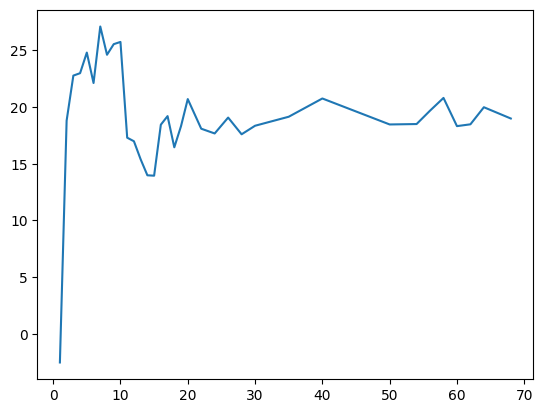

In [20]:
plt.plot(x_width[:len(x_complexity)], np.log(x_complexity[:]))

In [81]:
x_width = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38,
            40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
            60, 65, 70, 75, 80,]# 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155,
            #160, 165, 170, 175, 180, 185, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 350,
            #400, 450, 500, 550, 600, 650, 700, 750, 800]

x_complexity = np.zeros(len(x_width))
for i in range(1):
    print(i)
    for j in range(len(x_width)):
        net = Net(width=x_width[j]).cuda()
        train(net, train_loader, test_loader, epochs=10)
        print("Width :", x_width[j])
        complexity = 0
        k = 0
        for data in test_loader:
            inputs, labels = data
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda().float()
            for input in inputs:
                complexity += compute_complexity(net, input)
                k += 1
                if k > 20:
                    break
            break

            
        x_complexity[j] += complexity / k

x_complexity = x_complexity / 1

Epoch 10/10 - Loss: 0.164
Test Loss: 0.058
Finished Training
Width : 80


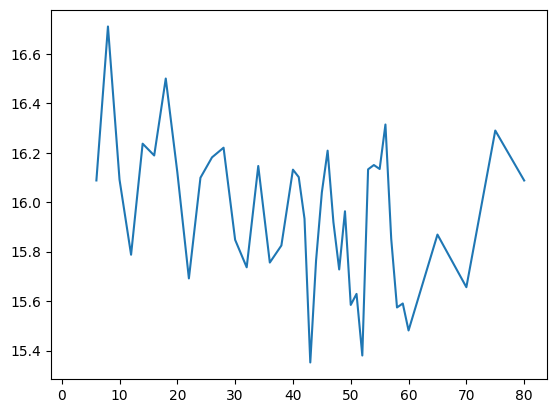

In [82]:
plt.plot(x_width, x_complexity)